In [1]:

# loading the required libraries 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from fancyimpute import KNN
import warnings
warnings.filterwarnings('ignore')
from geopy.distance import geodesic
from geopy.distance import great_circle
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.externals import joblib

Using TensorFlow backend.


In [2]:
# set the working directory
os.chdir('E:/Study Material/Data Science/Learning Data Science edWisor/Projects/Cab fare prediction')
os.getcwd()

'E:\\Study Material\\Data Science\\Learning Data Science edWisor\\Projects\\Cab fare prediction'

In [3]:
# Importing data
train = pd.read_csv('train_cab.csv',na_values={'fare_amount':'430-'})
test = pd.read_csv('test.csv')
data=[train,test]
for i in data:
    i['pickup_datetime']  = pd.to_datetime(i['pickup_datetime'],errors='coerce')

In [4]:
train.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   fare_amount        16042 non-null  float64            
 1   pickup_datetime    16066 non-null  datetime64[ns, UTC]
 2   pickup_longitude   16067 non-null  float64            
 3   pickup_latitude    16067 non-null  float64            
 4   dropoff_longitude  16067 non-null  float64            
 5   dropoff_latitude   16067 non-null  float64            
 6   passenger_count    16012 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6)
memory usage: 878.8 KB


In [6]:
cat_var=['passenger_count']
num_var=['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

# Graphical EDA

In [7]:
# setting up the sns for plots
sns.set(style='darkgrid',palette='Set1')

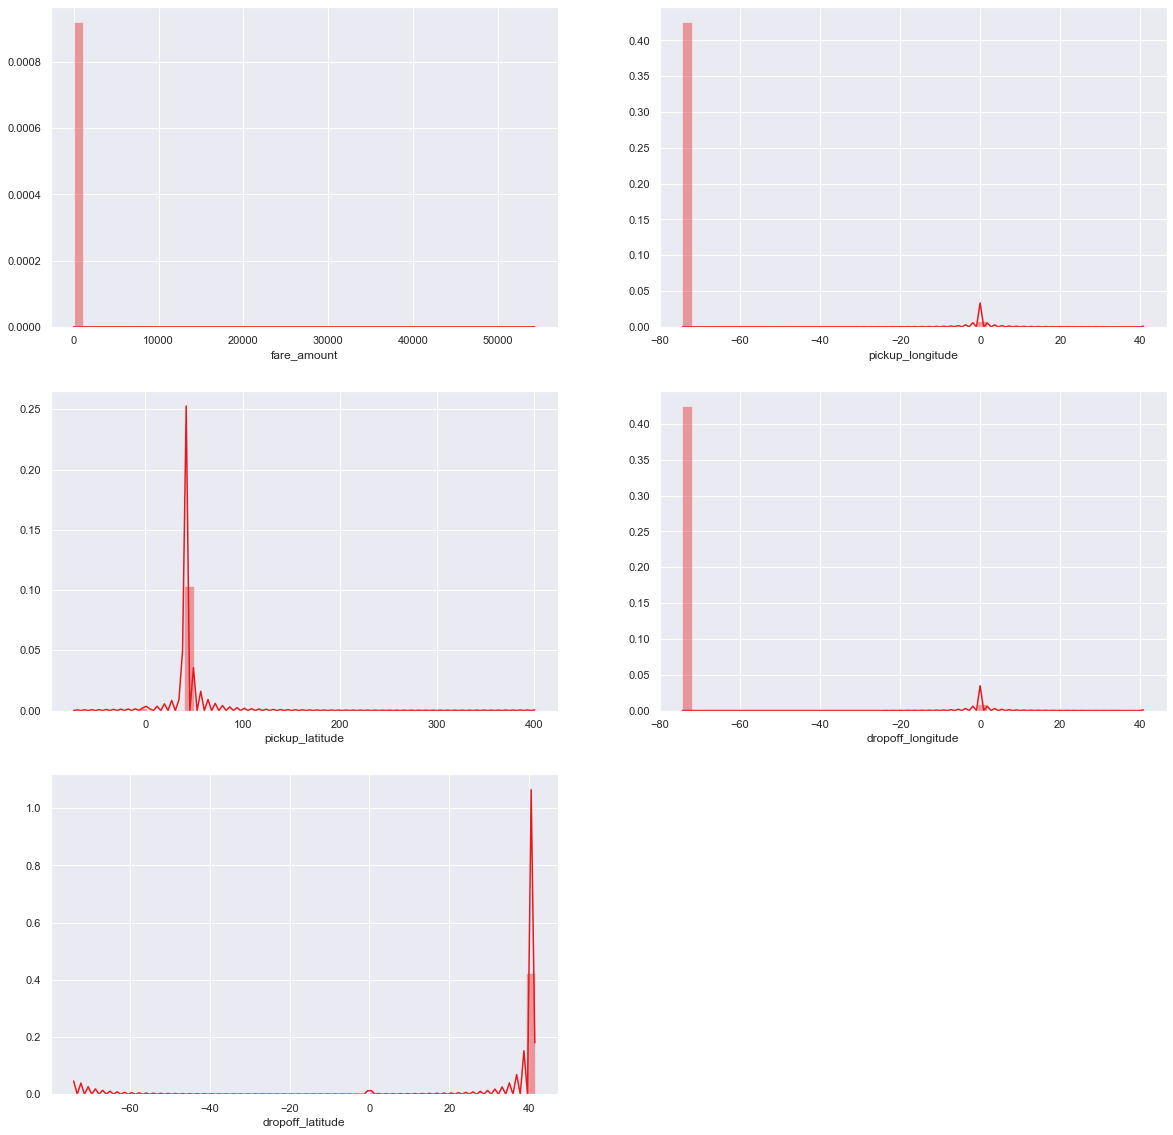

In [8]:
plt.figure(figsize=(20,20))
plt.subplot(321)
_ = sns.distplot(train['fare_amount'],bins=50)
plt.subplot(322)
_ = sns.distplot(train['pickup_longitude'],bins=50)
plt.subplot(323)
_ = sns.distplot(train['pickup_latitude'],bins=50)
plt.subplot(324)
_ = sns.distplot(train['dropoff_longitude'],bins=50)
plt.subplot(325)
_ = sns.distplot(train['dropoff_latitude'],bins=50)
# plt.savefig('hist.png')
plt.show()

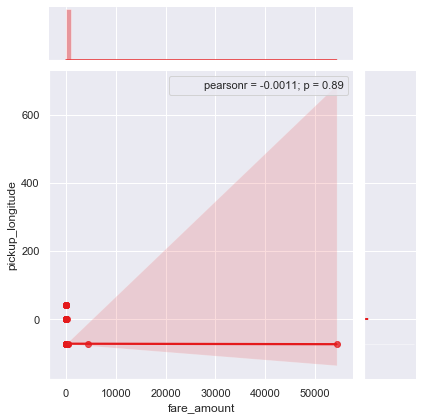

In [9]:
_ = sns.jointplot(x='fare_amount',y='pickup_longitude',data=train,kind = 'reg')
_.annotate(stats.pearsonr)
# plt.savefig('jointfplo.png')
plt.show()


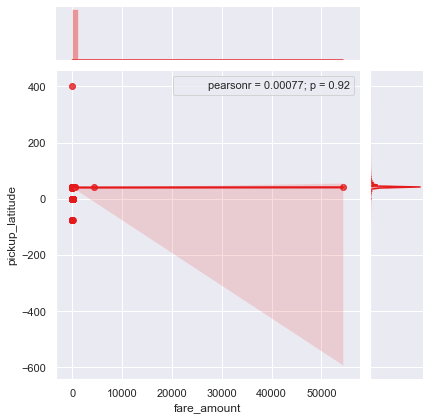

In [10]:
_ = sns.jointplot(x='fare_amount',y='pickup_latitude',data=train,kind = 'reg')
_.annotate(stats.pearsonr)
# plt.savefig('jointfpla.png')
plt.show()

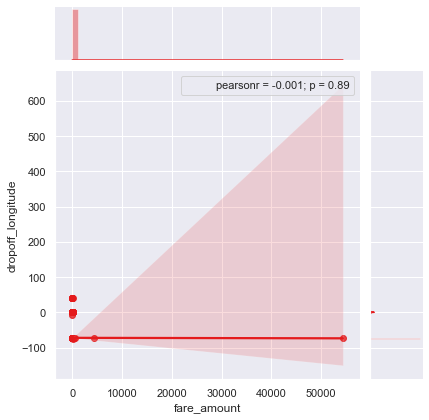

In [11]:

_ = sns.jointplot(x='fare_amount',y='dropoff_longitude',data=train,kind = 'reg')
_.annotate(stats.pearsonr)
# plt.savefig('jointfdlo.png')
plt.show()

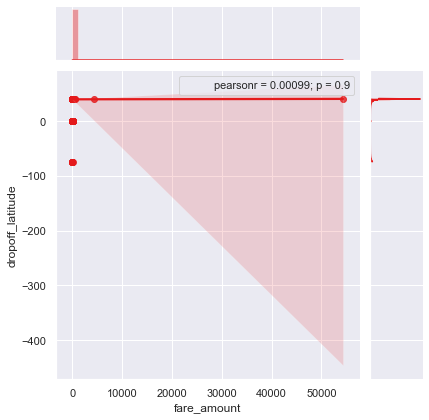

In [12]:

_ = sns.jointplot(x='fare_amount',y='dropoff_latitude',data=train,kind = 'reg')
_.annotate(stats.pearsonr)
# plt.savefig('jointfdla.png')
plt.show()

In [13]:
# Removing values which are not within desired range(outlier) depending upon basic understanding of dataset

In [14]:
sum(train['fare_amount']<1)

5

In [15]:
train[train['fare_amount']<1]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2039,-2.90,2010-03-09 23:37:10+00:00,-73.789450,40.643498,-73.788665,40.641952,1.0
2486,-2.50,2015-03-22 05:14:27+00:00,-74.000031,40.720631,-73.999809,40.720539,1.0
2780,0.01,2015-05-01 15:38:41+00:00,-73.939041,40.713963,-73.941673,40.713997,1.0
10002,0.00,2010-02-15 14:26:01+00:00,-73.987115,40.738808,-74.005911,40.713960,1.0
13032,-3.00,2013-08-30 08:57:10+00:00,-73.995062,40.740755,-73.995885,40.741357,4.0


In [16]:
train = train.drop(train[train['fare_amount']<1].index, axis=0)


In [17]:
for i in range(4,11):
    print('passenger_count above' +str(i)+'={}'.format(sum(train['passenger_count']>i)))

passenger_count above4=1367
passenger_count above5=322
passenger_count above6=20
passenger_count above7=20
passenger_count above8=20
passenger_count above9=20
passenger_count above10=20


In [18]:
train[train['passenger_count']>6]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
233,8.5,2011-07-24 01:14:35+00:00,0.000000,0.000000,0.000000,0.000000,236.0
263,4.9,2010-07-12 09:44:33+00:00,-73.983249,40.734655,-73.991278,40.738918,456.0
293,6.1,2011-01-18 23:48:00+00:00,-74.006642,40.738927,-74.010828,40.717907,5334.0
356,8.5,2013-06-18 10:27:05+00:00,-73.992108,40.764203,-73.973000,40.762695,535.0
386,8.1,2009-08-21 19:35:05+00:00,-73.960853,40.761557,-73.976335,40.748361,354.0
413,NaN,2013-09-12 11:32:00+00:00,-73.982060,40.772705,-73.956213,40.771777,55.0
971,10.1,2010-11-21 01:41:00+00:00,-74.004500,40.742143,-73.994330,40.720412,554.0
1007,3.7,2010-12-14 14:46:00+00:00,-73.969157,40.759000,-73.968763,40.764617,53.0
1043,5.7,2012-08-22 22:08:29+00:00,-73.973573,40.760184,-73.953564,40.767392,35.0
1107,4.9,2009-08-08 21:50:50+00:00,-73.988977,40.721068,-73.982368,40.732064,345.0


In [19]:
train[train['passenger_count']<1]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
314,34.0,2015-06-02 23:16:15+00:00,-73.974899,40.751095,-73.908546,40.881878,0.00
566,4.9,2012-01-28 21:33:18+00:00,-73.955322,40.782840,-73.955797,40.773673,0.00
678,6.5,2012-02-27 07:24:20+00:00,-73.983397,40.738183,-73.971395,40.758023,0.00
1160,13.3,2011-05-25 23:58:48+00:00,-73.998360,40.740348,-73.946455,40.777348,0.00
1935,10.1,2011-10-23 11:09:28+00:00,-73.971400,40.795000,-73.967900,40.768600,0.00
2200,8.1,2011-05-23 16:54:19+00:00,-73.988008,40.748303,-74.005185,40.738733,0.00
2425,8.9,2011-11-25 22:47:33+00:00,-73.999900,40.738600,-73.971800,40.746300,0.00
3034,5.7,2011-03-06 12:03:14+00:00,-73.986557,40.745783,-73.994545,40.729995,0.00
3413,7.3,2011-02-28 06:39:16+00:00,-73.973413,40.743708,-73.985220,40.741583,0.00
3481,11.3,2011-11-30 17:23:02+00:00,-73.968100,40.762500,-73.984400,40.760900,0.00


In [20]:

len(train[train['passenger_count']<1])

58

In [21]:
test['passenger_count'].unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

In [22]:
train = train.drop(train[train['passenger_count']>6].index, axis=0)
train = train.drop(train[train['passenger_count']<1].index, axis=0)

In [23]:
sum(train['passenger_count']>6)

0

In [24]:
print('pickup_longitude above 180={}'.format(sum(train['pickup_longitude']>180)))
print('pickup_longitude below -180={}'.format(sum(train['pickup_longitude']<-180)))
print('pickup_latitude above 90={}'.format(sum(train['pickup_latitude']>90)))
print('pickup_latitude below -90={}'.format(sum(train['pickup_latitude']<-90)))
print('dropoff_longitude above 180={}'.format(sum(train['dropoff_longitude']>180)))
print('dropoff_longitude below -180={}'.format(sum(train['dropoff_longitude']<-180)))
print('dropoff_latitude below -90={}'.format(sum(train['dropoff_latitude']<-90)))
print('dropoff_latitude above 90={}'.format(sum(train['dropoff_latitude']>90)))

pickup_longitude above 180=0
pickup_longitude below -180=0
pickup_latitude above 90=1
pickup_latitude below -90=0
dropoff_longitude above 180=0
dropoff_longitude below -180=0
dropoff_latitude below -90=0
dropoff_latitude above 90=0


In [25]:
for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    print(i,'equal to 0={}'.format(sum(train[i]==0)))


pickup_longitude equal to 0=311
pickup_latitude equal to 0=311
dropoff_longitude equal to 0=312
dropoff_latitude equal to 0=310


In [26]:
train = train.drop(train[train['pickup_latitude']>90].index, axis=0)
for i in ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']:
    train = train.drop(train[train[i]==0].index, axis=0)

In [27]:
train.shape

(15661, 7)

In [28]:
df=train.copy()
# train=df.copy()

# Missing value Analysis

In [29]:
#Create dataframe with missing percentage
missing_val = pd.DataFrame(train.isnull().sum())
#Reset index
missing_val = missing_val.reset_index()
missing_val

,index,0
0,fare_amount,22
1,pickup_datetime,1
2,pickup_longitude,0
3,pickup_latitude,0
4,dropoff_longitude,0
5,dropoff_latitude,0
6,passenger_count,55


In [30]:
#Rename variable
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'Missing_percentage'})
missing_val
#Calculate percentage
missing_val['Missing_percentage'] = (missing_val['Missing_percentage']/len(train))*100
#descending order
missing_val = missing_val.sort_values('Missing_percentage', ascending = False).reset_index(drop = True)
missing_val

,Variables,Missing_percentage
0,passenger_count,0.351191
1,fare_amount,0.140476
2,pickup_datetime,0.006385
3,pickup_longitude,0.000000
4,pickup_latitude,0.000000
5,dropoff_longitude,0.000000
6,dropoff_latitude,0.000000


In [31]:
# Choosing a random values to replace it as NA
train['passenger_count'].loc[1000]

1.0

In [32]:
# Replacing 1.0 with NA
train['passenger_count'].loc[1000] = np.nan
train['passenger_count'].loc[1000]

nan

In [33]:
# Impute with mode
train['passenger_count'].fillna(train['passenger_count'].mode()[0]).loc[1000]

1.0

In [34]:
# Choosing a random values to replace it as NA
a=train['fare_amount'].loc[1000]
print('fare_amount at loc-1000:{}'.format(a))
# Replacing 1.0 with NA
train['fare_amount'].loc[1000] = np.nan
print('Value after replacing with nan:{}'.format(train['fare_amount'].loc[1000]))
# Impute with mean
print('Value if imputed with mean:{}'.format(train['fare_amount'].fillna(train['fare_amount'].mean()).loc[1000]))
# Impute with median
print('Value if imputed with median:{}'.format(train['fare_amount'].fillna(train['fare_amount'].median()).loc[1000]))

fare_amount at loc-1000:7.0
Value after replacing with nan:nan
Value if imputed with mean:15.118196060877201
Value if imputed with median:8.5


In [35]:

train.std()

fare_amount          435.982171
pickup_longitude       2.659050
pickup_latitude        2.613305
dropoff_longitude      2.710835
dropoff_latitude       2.632400
passenger_count        1.266096
dtype: float64

In [36]:
columns=['fare_amount', 'pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude', 'passenger_count']

In [37]:
pickup_datetime=pd.DataFrame(train['pickup_datetime'])

In [38]:
# Imputing with missing values using KNN
# Use 181 nearest rows which have a feature to fill in each row's missing features
train = pd.DataFrame(KNN(k = 11).fit_transform(train.drop('pickup_datetime',axis=1)),columns=columns, index=train.index)

Imputing row 1/15661 with 0 missing, elapsed time: 369.317
Imputing row 101/15661 with 0 missing, elapsed time: 374.530
Imputing row 201/15661 with 0 missing, elapsed time: 375.996
Imputing row 301/15661 with 0 missing, elapsed time: 376.227
Imputing row 401/15661 with 0 missing, elapsed time: 376.355
Imputing row 501/15661 with 0 missing, elapsed time: 376.826
Imputing row 601/15661 with 0 missing, elapsed time: 377.218
Imputing row 701/15661 with 0 missing, elapsed time: 377.540
Imputing row 801/15661 with 0 missing, elapsed time: 377.885
Imputing row 901/15661 with 0 missing, elapsed time: 378.263
Imputing row 1001/15661 with 0 missing, elapsed time: 378.366
Imputing row 1101/15661 with 0 missing, elapsed time: 378.386
Imputing row 1201/15661 with 0 missing, elapsed time: 378.388
Imputing row 1301/15661 with 0 missing, elapsed time: 378.389
Imputing row 1401/15661 with 0 missing, elapsed time: 378.425
Imputing row 1501/15661 with 0 missing, elapsed time: 378.483
Imputing row 1601/15

In [39]:
train.std()

fare_amount          435.661999
pickup_longitude       2.659050
pickup_latitude        2.613305
dropoff_longitude      2.710835
dropoff_latitude       2.632400
passenger_count        1.264303
dtype: float64

In [40]:
train.loc[1000]

fare_amount           7.742634
pickup_longitude    -73.995420
pickup_latitude      40.759662
dropoff_longitude   -73.987607
dropoff_latitude     40.751247
passenger_count       2.810674
Name: 1000, dtype: float64

In [41]:
train['passenger_count'].head()

0    1.0
1    1.0
2    2.0
3    1.0
4    1.0
Name: passenger_count, dtype: float64

In [42]:
train['passenger_count']=train['passenger_count'].astype('int')

In [43]:
train.std()

fare_amount          435.661999
pickup_longitude       2.659050
pickup_latitude        2.613305
dropoff_longitude      2.710835
dropoff_latitude       2.632400
passenger_count        1.264443
dtype: float64

In [44]:
train['passenger_count'].unique()

array([1, 2, 3, 6, 5, 4])

In [45]:
train['passenger_count']=train['passenger_count'].round().astype('object')

In [46]:
train['passenger_count'].unique()

array([1, 2, 3, 6, 5, 4], dtype=object)

In [47]:
train['passenger_count']=pd.Categorical(train['passenger_count'],ordered=True)

In [48]:
train['passenger_count'].unique()

[1, 2, 3, 6, 5, 4]
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

In [49]:
train.loc[1000]

fare_amount          7.74263
pickup_longitude    -73.9954
pickup_latitude      40.7597
dropoff_longitude   -73.9876
dropoff_latitude     40.7512
passenger_count            2
Name: 1000, dtype: object

In [50]:
pickup_datetime.head()

,pickup_datetime
0,2009-06-15 17:26:21+00:00
1,2010-01-05 16:52:16+00:00
2,2011-08-18 00:35:00+00:00
3,2012-04-21 04:30:42+00:00
4,2010-03-09 07:51:00+00:00


In [51]:
#Checking missing value in Pickup_datetime
#Create dataframe with missing percentage
missing_val = pd.DataFrame(pickup_datetime.isnull().sum())
#Reset index
missing_val = missing_val.reset_index()
missing_val

,index,0
0,pickup_datetime,1


In [52]:
#we will drop 1 row which has missing value for pickup_datetime variable after feature engineering step because if we drop now, pickup_datetime dataframe will have 16040 rows and our train has 1641 rows, then if we merge these 2 dataframes then pickup_datetime variable will gain 1 missing value.
#And if we merge and then drop now then we would require to split again before outlier analysis and then merge again in feature engineering step.
#So, instead of doing the work 2 times we will drop 1 time i.e. after feature engineering process.

In [53]:

df1 = train.copy()
#train=df1.copy()

In [54]:

train['passenger_count'].describe()

count     15661
unique        6
top           1
freq      11055
Name: passenger_count, dtype: int64

In [55]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000
mean,15.111036,-73.911514,40.689712,-73.906315,40.687655
std,435.661999,2.659050,2.613305,2.710835,2.632400
min,1.140000,-74.438233,-74.006893,-74.429332,-74.006377
25%,6.000000,-73.992390,40.736530,-73.991369,40.736293
50%,8.500000,-73.982049,40.753300,-73.980555,40.754242
75%,12.500000,-73.968080,40.767805,-73.965360,40.768312
max,54343.000000,40.766125,41.366138,40.802437,41.366138


# Outlier Analysis

In [56]:
# Outlier analysis will be done only on fare_amount variable because Outlier Analysis 
#on other variables will be done after Feature Engineering 
#as the Pickup and Dropoff latitudes and longitudes will be converted into numerical distance. 

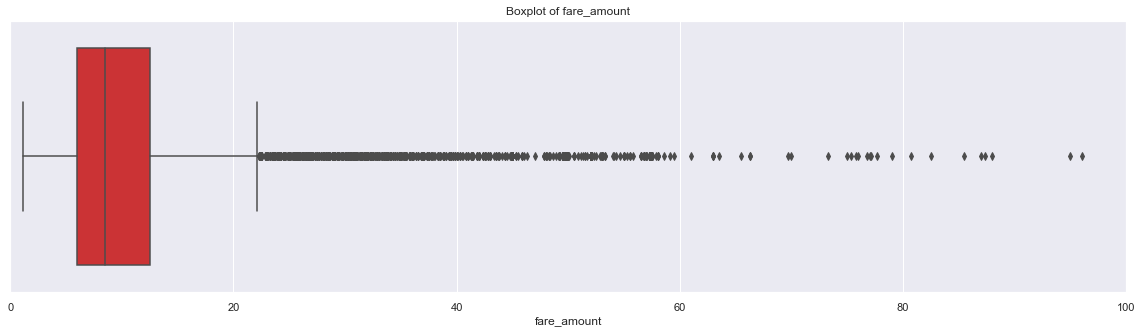

In [57]:
plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=train['fare_amount'],data=train,orient='h')
plt.title('Boxplot of fare_amount')
# plt.savefig('bp of fare_amount.png')
plt.show()

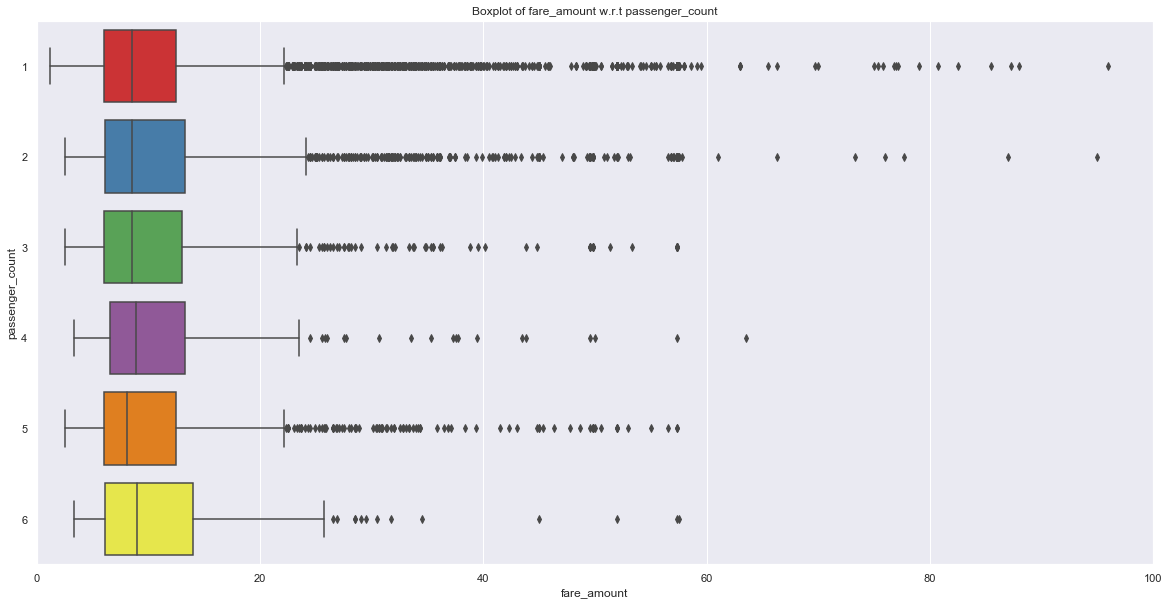

In [58]:
plt.figure(figsize=(20,10))
plt.xlim(0,100)
_ = sns.boxplot(x=train['fare_amount'],y=train['passenger_count'],data=train,orient='h')
plt.title('Boxplot of fare_amount w.r.t passenger_count')
# plt.savefig('Boxplot of fare_amount w.r.t passenger_count.png')
plt.show()

In [59]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000
mean,15.111036,-73.911514,40.689712,-73.906315,40.687655
std,435.661999,2.659050,2.613305,2.710835,2.632400
min,1.140000,-74.438233,-74.006893,-74.429332,-74.006377
25%,6.000000,-73.992390,40.736530,-73.991369,40.736293
50%,8.500000,-73.982049,40.753300,-73.980555,40.754242
75%,12.500000,-73.968080,40.767805,-73.965360,40.768312
max,54343.000000,40.766125,41.366138,40.802437,41.366138


In [60]:
train['passenger_count'].describe()

count     15661
unique        6
top           1
freq      11055
Name: passenger_count, dtype: int64

In [61]:
def outlier_treatment(col):
    ''' calculating outlier indices and replacing them with NA  '''
    #Extract quartiles
    q75, q25 = np.percentile(train[col], [75 ,25])
    print(q75,q25)
    #Calculate IQR
    iqr = q75 - q25
    #Calculate inner and outer fence
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    print(minimum,maximum)
    #Replace with NA
    train.loc[train[col] < minimum,col] = np.nan
    train.loc[train[col] > maximum,col] = np.nan

In [62]:
for i in num_var:
    outlier_treatment('fare_amount')
#     outlier_treatment('pickup_longitude')
#     outlier_treatment('pickup_latitude')
#     outlier_treatment('dropoff_longitude')
#     outlier_treatment('dropoff_latitude')

12.5 6.0
-3.75 22.25
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


In [63]:
pd.DataFrame(train.isnull().sum())

,0
fare_amount,1359
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [64]:
train.std()

fare_amount          4.137183
pickup_longitude     2.659050
pickup_latitude      2.613305
dropoff_longitude    2.710835
dropoff_latitude     2.632400
passenger_count      1.264443
dtype: float64

In [65]:
#Imputing with missing values using KNN
train = pd.DataFrame(KNN(k = 3).fit_transform(train), columns = train.columns, index=train.index)

Imputing row 1/15661 with 0 missing, elapsed time: 249.091
Imputing row 101/15661 with 0 missing, elapsed time: 251.994
Imputing row 201/15661 with 0 missing, elapsed time: 252.399
Imputing row 301/15661 with 1 missing, elapsed time: 252.735
Imputing row 401/15661 with 0 missing, elapsed time: 253.526
Imputing row 501/15661 with 0 missing, elapsed time: 254.282
Imputing row 601/15661 with 1 missing, elapsed time: 254.559
Imputing row 701/15661 with 0 missing, elapsed time: 254.890
Imputing row 801/15661 with 0 missing, elapsed time: 255.261
Imputing row 901/15661 with 0 missing, elapsed time: 255.562
Imputing row 1001/15661 with 0 missing, elapsed time: 256.042
Imputing row 1101/15661 with 1 missing, elapsed time: 256.773
Imputing row 1201/15661 with 0 missing, elapsed time: 257.620
Imputing row 1301/15661 with 0 missing, elapsed time: 258.116
Imputing row 1401/15661 with 0 missing, elapsed time: 258.655
Imputing row 1501/15661 with 0 missing, elapsed time: 258.994
Imputing row 1601/15

In [66]:
train.std()

fare_amount          4.478147
pickup_longitude     2.659050
pickup_latitude      2.613305
dropoff_longitude    2.710835
dropoff_latitude     2.632400
passenger_count      1.264443
dtype: float64

In [67]:
train['passenger_count'].describe()

count    15661.000000
mean         1.649448
std          1.264443
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: passenger_count, dtype: float64

In [68]:
train['passenger_count']=train['passenger_count'].astype('int').round().astype('object').astype('category')

In [69]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000
mean,9.405221,-73.911514,40.689712,-73.906315,40.687655
std,4.478147,2.659050,2.613305,2.710835,2.632400
min,1.140000,-74.438233,-74.006893,-74.429332,-74.006377
25%,6.000000,-73.992390,40.736530,-73.991369,40.736293
50%,8.200000,-73.982049,40.753300,-73.980555,40.754242
75%,11.800000,-73.968080,40.767805,-73.965360,40.768312
max,22.100000,40.766125,41.366138,40.802437,41.366138


In [70]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1


In [71]:
train['passenger_count']=pd.Categorical(train['passenger_count'],ordered=True)

In [72]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,15661.000000,15661.000000,15661.000000,15661.000000,15661.000000
mean,9.405221,-73.911514,40.689712,-73.906315,40.687655
std,4.478147,2.659050,2.613305,2.710835,2.632400
min,1.140000,-74.438233,-74.006893,-74.429332,-74.006377
25%,6.000000,-73.992390,40.736530,-73.991369,40.736293
50%,8.200000,-73.982049,40.753300,-73.980555,40.754242
75%,11.800000,-73.968080,40.767805,-73.965360,40.768312
max,22.100000,40.766125,41.366138,40.802437,41.366138


In [73]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1


In [74]:
df2 = train.copy()
# train=df2.copy()

# Feature Engineering

In [75]:
# we will Join 2 Dataframes pickup_datetime and train
train = pd.merge(pickup_datetime,train,right_index=True,left_index=True)
train.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21+00:00,4.5,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16+00:00,16.9,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00+00:00,5.7,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42+00:00,7.7,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00+00:00,5.3,-73.968095,40.768008,-73.956655,40.783762,1


In [76]:
train.shape

(15661, 7)

In [77]:
train=train.reset_index(drop=True)

In [78]:
pd.DataFrame(train.isna().sum())

,0
pickup_datetime,1
fare_amount,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [79]:
train=train.dropna()

In [80]:
data = [train,test]
for i in data:
    i["year"] = i["pickup_datetime"].apply(lambda row: row.year)
    i["month"] = i["pickup_datetime"].apply(lambda row: row.month)
#     i["day_of_month"] = i["pickup_datetime"].apply(lambda row: row.day)
    i["day_of_week"] = i["pickup_datetime"].apply(lambda row: row.dayofweek)
    i["hour"] = i["pickup_datetime"].apply(lambda row: row.hour)

In [81]:

# train_nodummies=train.copy()
# train=train_nodummies.copy()

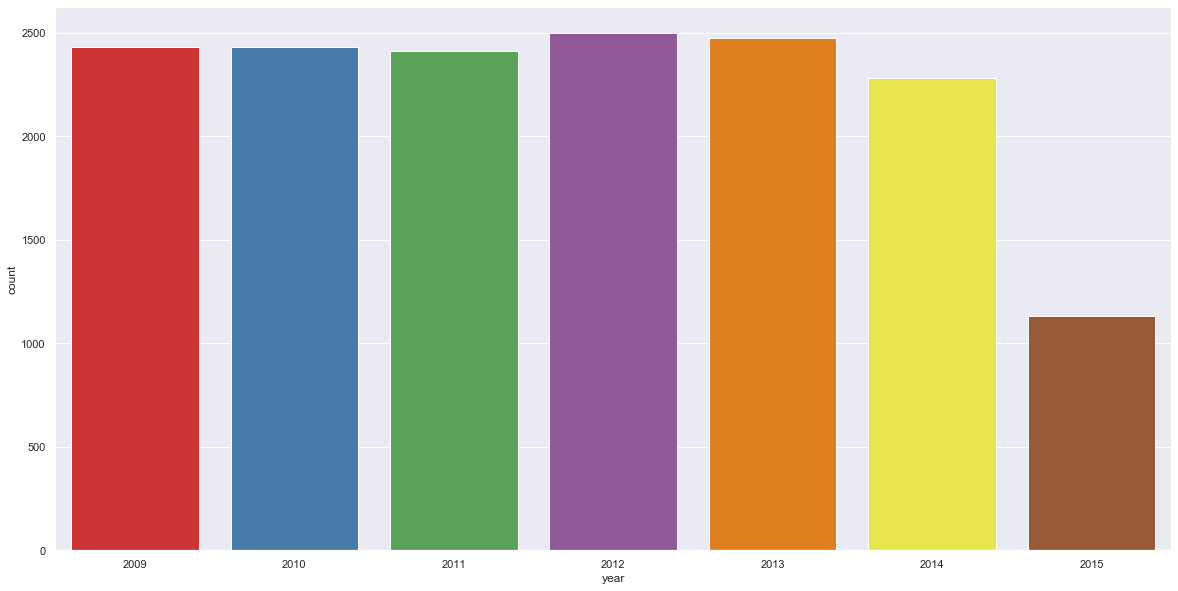

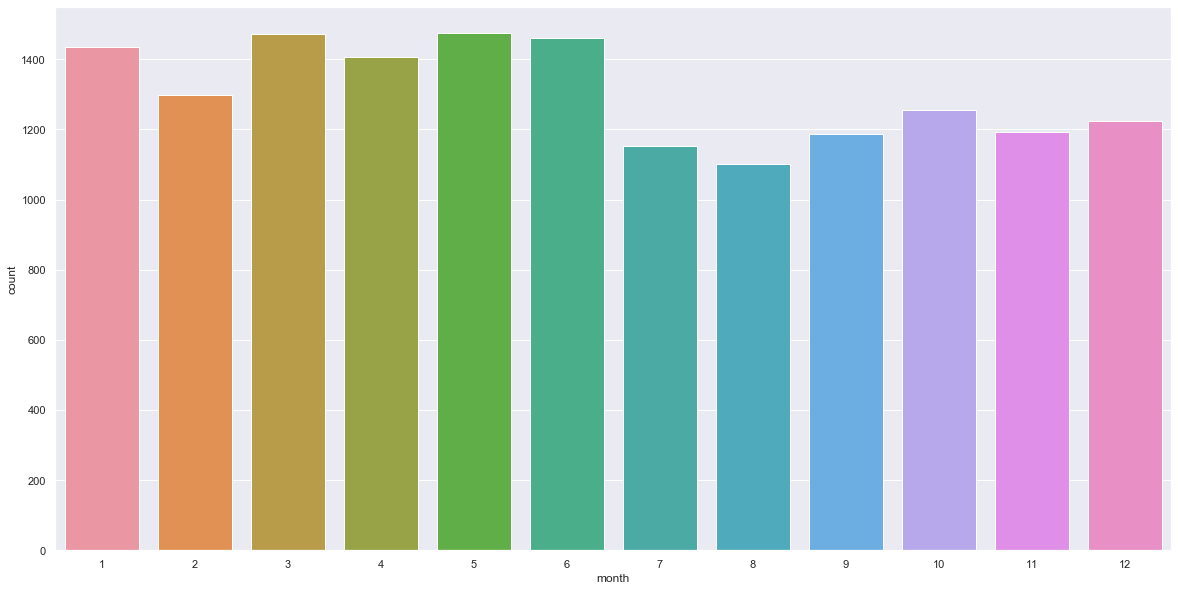

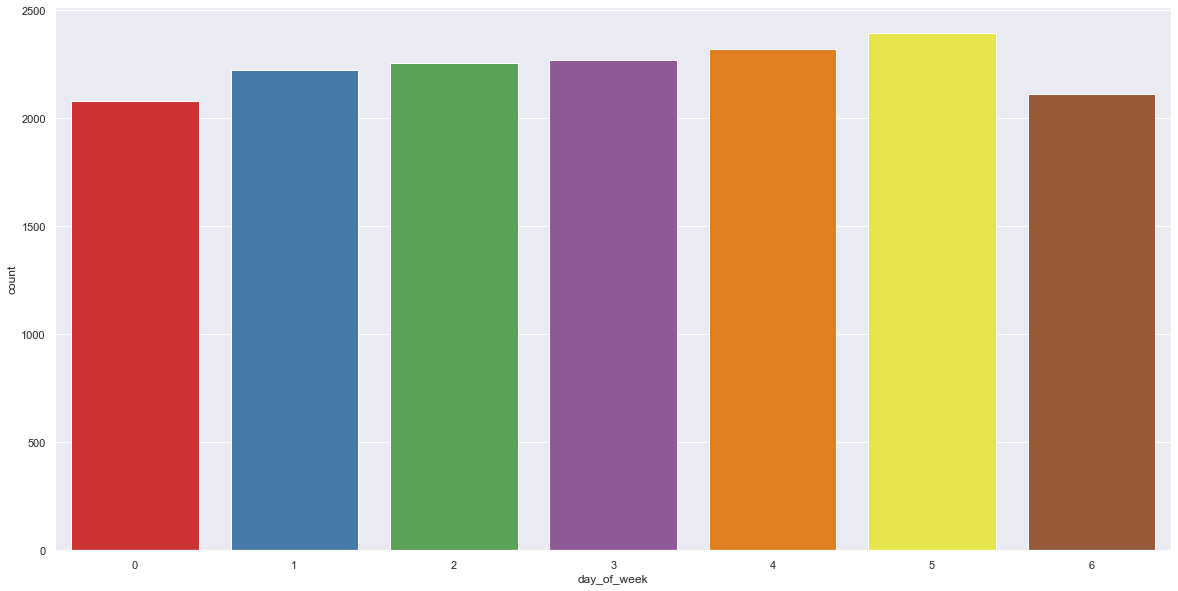

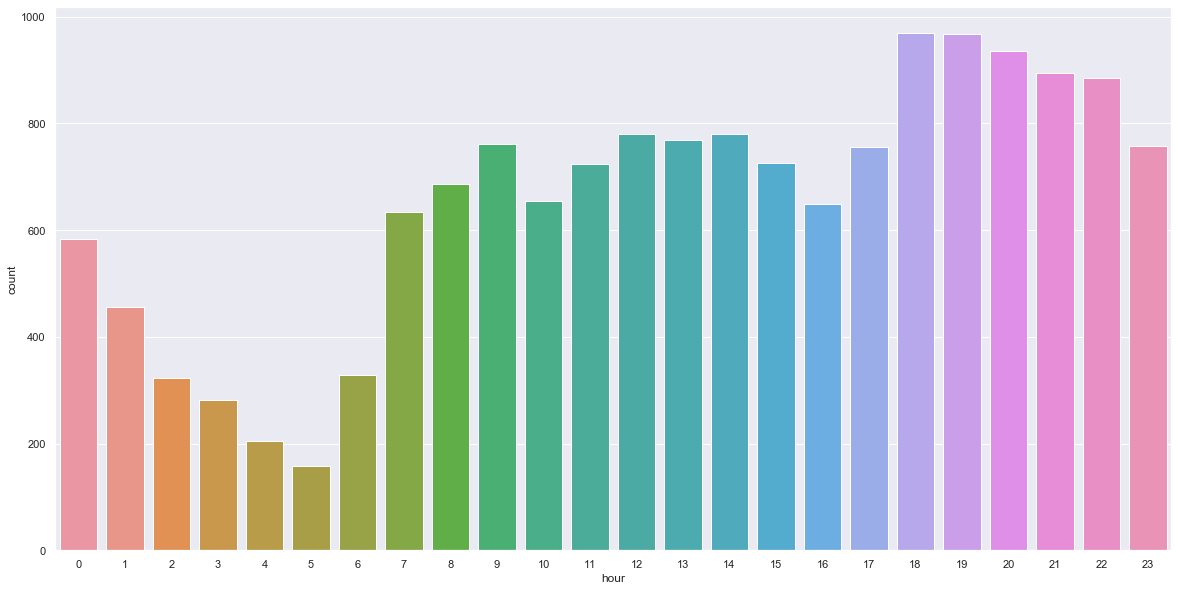

In [82]:

plt.figure(figsize=(20,10))
sns.countplot(train['year'])
# plt.savefig('year.png')

plt.figure(figsize=(20,10))
sns.countplot(train['month'])
# plt.savefig('month.png')

plt.figure(figsize=(20,10))
sns.countplot(train['day_of_week'])
# plt.savefig('day_of_week.png')

plt.figure(figsize=(20,10))
sns.countplot(train['hour'])
# plt.savefig('hour.png')

In [83]:
def f(x):
    ''' for sessions in a day using hour column '''
    if (x >=5) and (x <= 11):
        return 'morning'
    elif (x >=12) and (x <=16 ):
        return 'afternoon'
    elif (x >= 17) and (x <= 20):
        return'evening'
    elif (x >=21) and (x <= 23) :
        return 'night'
    elif (x >=0) and (x <=4):
        return'night'

In [84]:

def g(x):
    ''' for seasons in a year using month column'''
    if (x >=3) and (x <= 5):
        return 'spring'
    elif (x >=6) and (x <=8 ):
        return 'summer'
    elif (x >= 9) and (x <= 11):
        return'fall'
    elif (x >=12)|(x <= 2) :
        return 'winter'

In [85]:
train['session'] = train['hour'].apply(f)
test['session'] = test['hour'].apply(f)
# train_nodummies['session'] = train_nodummies['hour'].apply(f)

In [86]:
train['seasons'] = train['month'].apply(g)
test['seasons'] = test['month'].apply(g)
# train['seasons'] = test['month'].apply(g)

In [87]:
train.shape

(15660, 13)

In [88]:
test.shape

(9914, 12)

# one hot encoding technique

In [89]:
df2 = train.copy()
df2test=test.copy()
#train=df2.copy()
#test=df2test.copy()

In [90]:
train.columns

Index(['pickup_datetime', 'fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons'],
      dtype='object')

In [91]:
test.columns

Index(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons'],
      dtype='object')

In [92]:
#Creating dummies for each variable in passenger_count and merging dummies dataframe to both train and test dataframe
temp = pd.get_dummies(train['passenger_count'], prefix = 'passenger_count')
train = train.join(temp)
temp = pd.get_dummies(test['passenger_count'], prefix = 'passenger_count')
test = test.join(temp)
temp = pd.get_dummies(train['seasons'], prefix = 'season')
train = train.join(temp)
temp = pd.get_dummies(test['seasons'], prefix = 'season')
test = test.join(temp)
temp = pd.get_dummies(train['session'], prefix = 'session')
train = train.join(temp)
temp = pd.get_dummies(test['session'], prefix = 'session')
test = test.join(temp)
temp = pd.get_dummies(train['year'], prefix = 'year')
train = train.join(temp)
temp = pd.get_dummies(test['year'], prefix = 'year')
test = test.join(temp)

In [93]:
train.columns

Index(['pickup_datetime', 'fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'session_afternoon', 'session_evening', 'session_morning',
       'session_night', 'year_2009', 'year_2010', 'year_2011', 'year_2012',
       'year_2013', 'year_2014', 'year_2015'],
      dtype='object')

In [94]:
test.columns

Index(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'session_afternoon', 'session_evening', 'session_morning',
       'session_night', 'year_2009', 'year_2010', 'year_2011', 'year_2012',
       'year_2013', 'year_2014', 'year_2015'],
      dtype='object')

In [95]:
train.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,...,session_evening,session_morning,session_night,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015
0,2009-06-15 17:26:21+00:00,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,...,1,0,0,1,0,0,0,0,0,0
1,2010-01-05 16:52:16+00:00,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,...,0,0,0,0,1,0,0,0,0,0
2,2011-08-18 00:35:00+00:00,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,...,0,0,1,0,0,1,0,0,0,0
3,2012-04-21 04:30:42+00:00,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,...,0,0,1,0,0,0,1,0,0,0
4,2010-03-09 07:51:00+00:00,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,...,0,1,0,0,1,0,0,0,0,0


In [96]:

test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_week,hour,...,session_evening,session_morning,session_night,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015
0,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13,...,0,0,0,0,0,0,0,0,0,1
1,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13,...,0,0,0,0,0,0,0,0,0,1
2,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11,...,0,1,0,0,0,1,0,0,0,0
3,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21,...,0,0,1,0,0,0,1,0,0,0
4,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21,...,0,0,1,0,0,0,1,0,0,0


In [97]:
train.columns

Index(['pickup_datetime', 'fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'session_afternoon', 'session_evening', 'session_morning',
       'session_night', 'year_2009', 'year_2010', 'year_2011', 'year_2012',
       'year_2013', 'year_2014', 'year_2015'],
      dtype='object')

In [98]:
test.columns

Index(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_week', 'hour', 'session', 'seasons',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_fall', 'season_spring', 'season_summer', 'season_winter',
       'session_afternoon', 'session_evening', 'session_morning',
       'session_night', 'year_2009', 'year_2010', 'year_2011', 'year_2012',
       'year_2013', 'year_2014', 'year_2015'],
      dtype='object')

In [99]:
train=train.drop(['passenger_count','passenger_count_1','seasons','day_of_week','year_2009','year','season_fall','session_afternoon','session','hour'],axis=1)
test=test.drop(['passenger_count','passenger_count_1','seasons','day_of_week','year_2009','year','season_fall','session_afternoon','session','hour'],axis=1)

In [100]:
train.columns

Index(['pickup_datetime', 'fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'month', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'season_spring', 'season_summer', 'season_winter',
       'session_evening', 'session_morning', 'session_night', 'year_2010',
       'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015'],
      dtype='object')

In [101]:
test.columns

Index(['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'month', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'season_spring', 'season_summer', 'season_winter',
       'session_evening', 'session_morning', 'session_night', 'year_2010',
       'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015'],
      dtype='object')

In [102]:
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15660 entries, 0 to 15660
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   pickup_datetime    15660 non-null  datetime64[ns, UTC]
 1   fare_amount        15660 non-null  float64            
 2   pickup_longitude   15660 non-null  float64            
 3   pickup_latitude    15660 non-null  float64            
 4   dropoff_longitude  15660 non-null  float64            
 5   dropoff_latitude   15660 non-null  float64            
 6   month              15660 non-null  int64              
 7   passenger_count_2  15660 non-null  uint8              
 8   passenger_count_3  15660 non-null  uint8              
 9   passenger_count_4  15660 non-null  uint8              
 10  passenger_count_5  15660 non-null  uint8              
 11  passenger_count_6  15660 non-null  uint8              
 12  season_spring      15660 non-null  uint8      

# Feature Engineering for latitude and longitude variable

In [103]:
# Calculate distance the cab travelled from pickup and dropoff location using great_circle from geopy library
data = [train, test]
for i in data:
    i['great_circle']=i.apply(lambda x: great_circle((x['pickup_latitude'],x['pickup_longitude']), (x['dropoff_latitude'],   x['dropoff_longitude'])).miles, axis=1)
    i['geodesic']=i.apply(lambda x: geodesic((x['pickup_latitude'],x['pickup_longitude']), (x['dropoff_latitude'],   x['dropoff_longitude'])).miles, axis=1)

In [104]:
train.head(20)

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,month,passenger_count_2,passenger_count_3,passenger_count_4,...,session_morning,session_night,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,great_circle,geodesic
0,2009-06-15 17:26:21+00:00,4.500000,-73.844311,40.721319,-73.841610,40.712278,6,0,0,0,...,0,0,0,0,0,0,0,0,0.640488,0.639764
1,2010-01-05 16:52:16+00:00,16.900000,-74.016048,40.711303,-73.979268,40.782004,1,0,0,0,...,0,0,1,0,0,0,0,0,5.250677,5.246511
2,2011-08-18 00:35:00+00:00,5.700000,-73.982738,40.761270,-73.991242,40.750562,8,1,0,0,...,0,1,0,1,0,0,0,0,0.863412,0.863167
3,2012-04-21 04:30:42+00:00,7.700000,-73.987130,40.733143,-73.991567,40.758092,4,0,0,0,...,0,1,0,0,1,0,0,0,1.739388,1.737223
4,2010-03-09 07:51:00+00:00,5.300000,-73.968095,40.768008,-73.956655,40.783762,3,0,0,0,...,1,0,1,0,0,0,0,0,1.242220,1.241710
5,2011-01-06 09:50:45+00:00,12.100000,-74.000964,40.731630,-73.972892,40.758233,1,0,0,0,...,1,0,0,1,0,0,0,0,2.353285,2.353742
6,2012-11-20 20:35:00+00:00,7.500000,-73.980002,40.751662,-73.973802,40.764842,11,0,0,0,...,0,0,0,0,1,0,0,0,0.966735,0.965888
7,2012-01-04 17:22:00+00:00,16.500000,-73.951300,40.774138,-73.990095,40.751048,1,0,0,0,...,0,0,0,0,1,0,0,0,2.582077,2.584861
8,2012-12-03 13:10:00+00:00,6.128253,-74.006462,40.726713,-73.993078,40.731628,12,0,0,0,...,0,0,0,0,1,0,0,0,0.778723,0.780136
9,2009-09-02 01:11:00+00:00,8.900000,-73.980658,40.733873,-73.991540,40.758138,9,1,0,0,...,0,1,0,0,0,0,0,0,1.770679,1.769061


In [105]:
pd.DataFrame(train.isna().sum())

,0
pickup_datetime,0
fare_amount,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
month,0
passenger_count_2,0
passenger_count_3,0
passenger_count_4,0


In [106]:
train=train.drop(['pickup_datetime','pickup_longitude','month','pickup_latitude','dropoff_longitude','dropoff_latitude','great_circle'],axis=1)
test=test.drop(['pickup_datetime','pickup_longitude','month','pickup_latitude','dropoff_longitude','dropoff_latitude','great_circle'],axis=1)

In [107]:
train.shape,test.shape

((15660, 19), (9914, 18))

In [108]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15660 entries, 0 to 15660
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        15660 non-null  float64
 1   passenger_count_2  15660 non-null  uint8  
 2   passenger_count_3  15660 non-null  uint8  
 3   passenger_count_4  15660 non-null  uint8  
 4   passenger_count_5  15660 non-null  uint8  
 5   passenger_count_6  15660 non-null  uint8  
 6   season_spring      15660 non-null  uint8  
 7   season_summer      15660 non-null  uint8  
 8   season_winter      15660 non-null  uint8  
 9   session_evening    15660 non-null  uint8  
 10  session_morning    15660 non-null  uint8  
 11  session_night      15660 non-null  uint8  
 12  year_2010          15660 non-null  uint8  
 13  year_2011          15660 non-null  uint8  
 14  year_2012          15660 non-null  uint8  
 15  year_2013          15660 non-null  uint8  
 16  year_2014          156

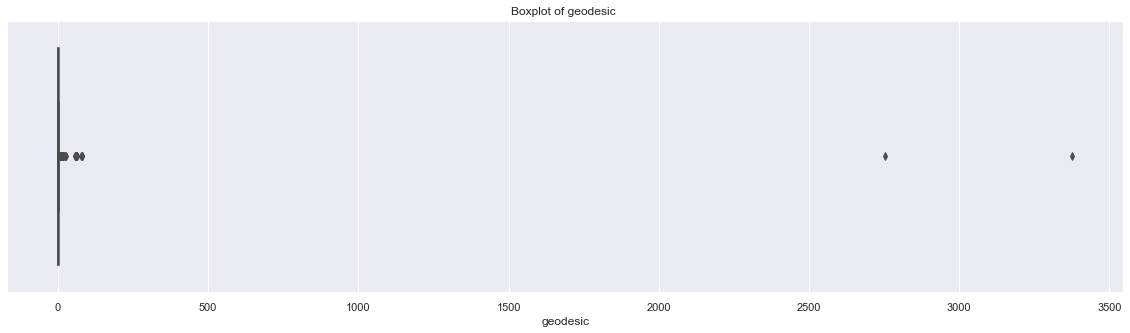

In [109]:
plt.figure(figsize=(20,5)) 
sns.boxplot(x=train['geodesic'],data=train,orient='h')
plt.title('Boxplot of geodesic ')
# plt.savefig('bp geodesic.png')
plt.show()

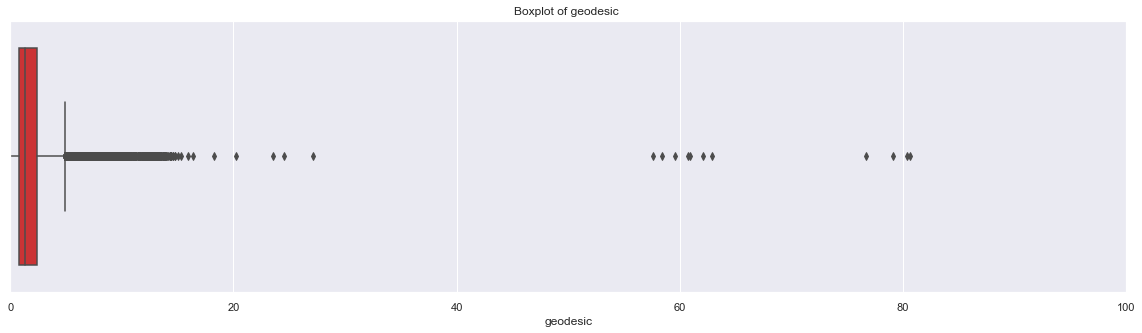

In [110]:

plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=train['geodesic'],data=train,orient='h')
plt.title('Boxplot of geodesic ')
# plt.savefig('bp geodesic.png')
plt.show()

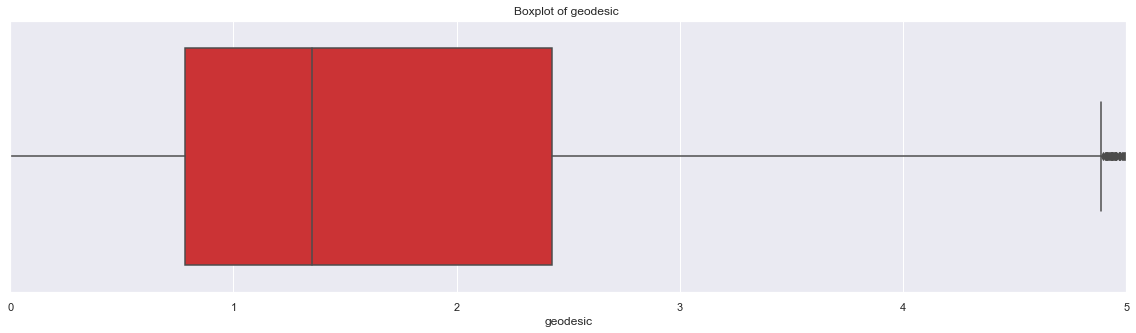

In [111]:

plt.figure(figsize=(20,5)) 
plt.xlim(0,5)
sns.boxplot(x=train['geodesic'],data=train,orient='h')
plt.title('Boxplot of geodesic ')
# plt.savefig('bp geodesic.png')
plt.show()

In [112]:
outlier_treatment('geodesic')

2.425668049965582 0.7815214474966259
-1.6846984562068081 4.891887953669016


In [113]:
pd.DataFrame(train.isnull().sum())

,0
fare_amount,0
passenger_count_2,0
passenger_count_3,0
passenger_count_4,0
passenger_count_5,0
passenger_count_6,0
season_spring,0
season_summer,0
season_winter,0
session_evening,0


In [114]:
#Imputing with missing values using KNN
train = pd.DataFrame(KNN(k = 3).fit_transform(train), columns = train.columns, index=train.index)

Imputing row 1/15660 with 0 missing, elapsed time: 387.602
Imputing row 101/15660 with 0 missing, elapsed time: 396.950
Imputing row 201/15660 with 0 missing, elapsed time: 398.796
Imputing row 301/15660 with 1 missing, elapsed time: 399.030
Imputing row 401/15660 with 0 missing, elapsed time: 399.329
Imputing row 501/15660 with 0 missing, elapsed time: 399.499
Imputing row 601/15660 with 1 missing, elapsed time: 399.606
Imputing row 701/15660 with 0 missing, elapsed time: 399.755
Imputing row 801/15660 with 0 missing, elapsed time: 399.937
Imputing row 901/15660 with 0 missing, elapsed time: 400.163
Imputing row 1001/15660 with 0 missing, elapsed time: 400.400
Imputing row 1101/15660 with 1 missing, elapsed time: 400.714
Imputing row 1201/15660 with 0 missing, elapsed time: 401.980
Imputing row 1301/15660 with 0 missing, elapsed time: 402.235
Imputing row 1401/15660 with 0 missing, elapsed time: 402.439
Imputing row 1501/15660 with 0 missing, elapsed time: 402.521
Imputing row 1601/15

In [115]:
train.head()

,fare_amount,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,season_spring,season_summer,season_winter,session_evening,session_morning,session_night,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,geodesic
0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.639764
1,16.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.388255
2,5.7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.863167
3,7.7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.737223
4,5.3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.241710


# Feature Selection


In [116]:
train.columns

Index(['fare_amount', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'season_spring', 'season_summer', 'season_winter', 'session_evening',
       'session_morning', 'session_night', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'geodesic'],
      dtype='object')

In [117]:
cat_var=['passenger_count_2','passenger_count_3','passenger_count_4','passenger_count_5','passenger_count_6',
         'season_spring','season_summer','season_winter','session_evening', 
         'session_morning','session_night', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015']
num_var=['fare_amount','geodesic']
train[cat_var]=train[cat_var].apply(lambda x: x.astype('category'))
test[cat_var]=test[cat_var].apply(lambda x: x.astype('category'))

## 1.Correlation Analysis

Statistically correlated: features move together directionally. Linear models assume feature independence. And if features are correlated that could introduce bias into our models

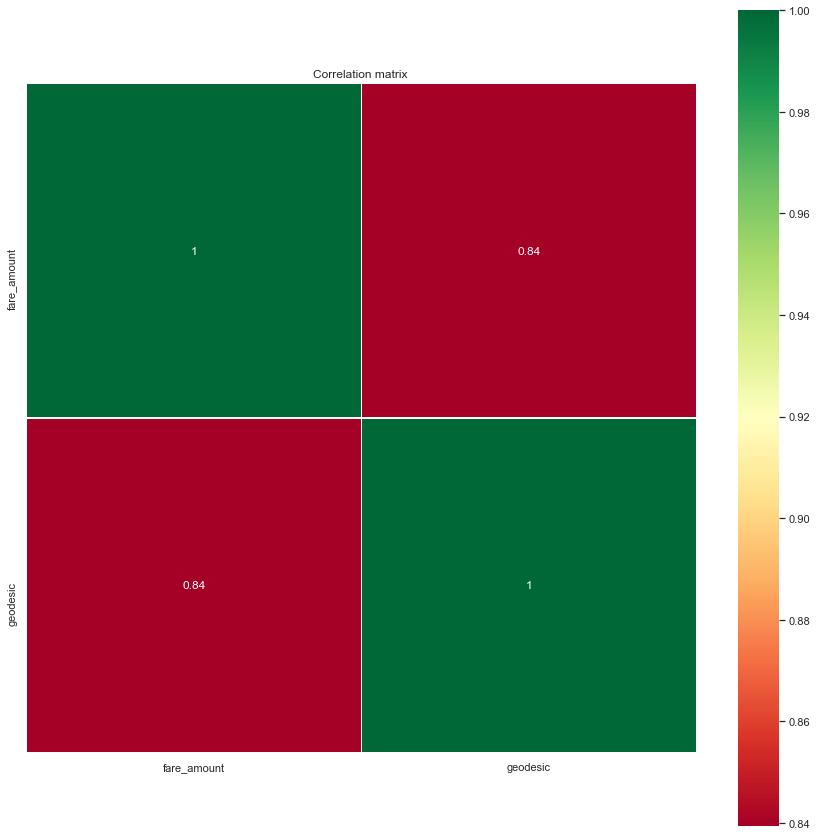

In [118]:
plt.figure(figsize=(15,15))
_ = sns.heatmap(train[num_var].corr(), square=True, cmap='RdYlGn',linewidths=0.5,linecolor='w',annot=True)
plt.title('Correlation matrix ')
# plt.savefig('correlation.png')
plt.show()

# Analysis of Variance(Anova) Test

In [119]:
model = ols('fare_amount ~ C(passenger_count_2)+C(passenger_count_3)+C(passenger_count_4)+C(passenger_count_5)+C(passenger_count_6)+C(season_spring)+C(season_summer)+C(season_winter)+C(session_night)+C(session_evening)+C(session_morning)+C(year_2010)+C(year_2011)+C(year_2012)+C(year_2013)+C(year_2014)+C(year_2015)',data=train).fit()
                
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(passenger_count_2),1.0,12.481020,12.481020,0.642233,4.229154e-01
C(passenger_count_3),1.0,15.373206,15.373206,0.791056,3.737947e-01
C(passenger_count_4),1.0,69.314600,69.314600,3.566707,5.896758e-02
C(passenger_count_5),1.0,20.893594,20.893594,1.075117,2.998084e-01
C(passenger_count_6),1.0,145.742153,145.742153,7.499424,6.178857e-03
C(season_spring),1.0,29.353506,29.353506,1.510437,2.190909e-01
C(season_summer),1.0,26.157543,26.157543,1.345983,2.459992e-01
C(season_winter),1.0,482.191601,482.191601,24.812035,6.387575e-07
C(session_night),1.0,1512.649494,1512.649494,77.836096,1.236034e-18
C(session_evening),1.0,0.919884,0.919884,0.047334,8.277713e-01


# Multicollinearity Test

In [120]:
outcome, predictors = dmatrices('fare_amount ~ geodesic+passenger_count_2+passenger_count_3+passenger_count_4+passenger_count_5+passenger_count_6+season_spring+season_summer+season_winter+session_night+session_evening+session_morning+year_2010+year_2011+year_2012+year_2013+year_2014+year_2015',train, return_type='dataframe')
# calculating VIF for each individual Predictors
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif["features"] = predictors.columns
vif

,VIF,features
0,14.902480,Intercept
1,1.037960,passenger_count_2[T.1.0]
2,1.017902,passenger_count_3[T.1.0]
3,1.010386,passenger_count_4[T.1.0]
4,1.024824,passenger_count_5[T.1.0]
5,1.017208,passenger_count_6[T.1.0]
6,1.642134,season_spring[T.1.0]
7,1.551563,season_summer[T.1.0]
8,1.587399,season_winter[T.1.0]
9,1.600564,session_night[T.1.0]


# Feature Scaling

In [121]:
train[num_var].var()

fare_amount    20.054803
geodesic        1.238111
dtype: float64

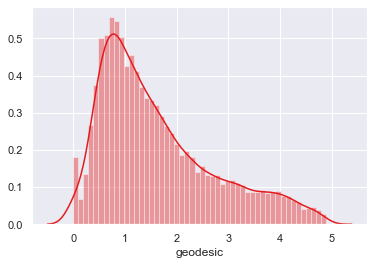

In [122]:
sns.distplot(train['geodesic'],bins=50)
# plt.savefig('distplot.png')

In [123]:

#Normalization
train['geodesic'] = (train['geodesic'] - min(train['geodesic']))/(max(train['geodesic']) - min(train['geodesic']))
test['geodesic'] = (test['geodesic'] - min(test['geodesic']))/(max(test['geodesic']) - min(test['geodesic']))

In [124]:
train['geodesic'].var()

0.05180406858785076

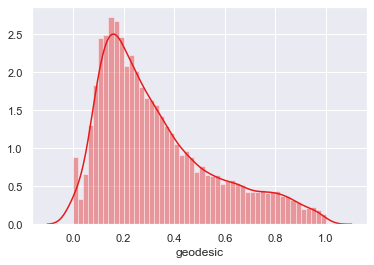

In [125]:
sns.distplot(train['geodesic'],bins=50)
plt.savefig('distplot.png')

In [126]:
df4=train.copy()
#train=df4.copy()
f4=test.copy()
#test=f4.copy()

# Splitting train into train and validation subsets

In [127]:
X = train.drop('fare_amount',axis=1).values
y = train['fare_amount'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)
print(train.shape, X_train.shape, X_test.shape,y_train.shape,y_test.shape)

(15660, 19) (11745, 18) (3915, 18) (11745,) (3915,)


# Defining Error Metrics 

In [128]:

def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def scores(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-X_train.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_))) 
def test_scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X_train)
    scores(y_train,y_pred)
    print('RMSLE:',rmsle(y_train,y_pred))
    print()
    print('<<<------------------- Test Data Score --------------------->')
    print()
    # Evaluating on Test Set
    y_pred = model.predict(X_test)
    scores(y_test,y_pred)
    print('RMSLE:',rmsle(y_test,y_pred))


# Multiple Linear Regression

In [146]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'copy_X':[True, False],
          'fit_intercept':[True,False]}
# Instantiate a Decision reg classifier: reg
reg = LinearRegression()

# Instantiate the gridSearchCV object: reg_cv
reg_cv = GridSearchCV(reg, param_dist, cv=5,scoring='r2')

# Fit it to the data
reg_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision reg Parameters: {}".format(reg_cv.best_params_))
print("Best score is {}".format(reg_cv.best_score_))

Tuned Decision reg Parameters: {'copy_X': True, 'fit_intercept': True}
Best score is 0.7317634604430727


R^2: 0.7353676744650031
Root Mean Squared Error: 2.3303155189690616
<<<------------------- Training Data Score --------------------->

r square   0.7316187270965101
Adjusted r square:0.7312067483388551
MAPE:18.805432776434042
MSE: 5.340177492832219
RMSE: 2.3108824056693624
RMSLE: 0.21781778674541533

<<<------------------- Test Data Score --------------------->

r square   0.7353676744650031
Adjusted r square:0.7341450405174594
MAPE:19.072932308689275
MSE: 5.430370417948047
RMSE: 2.3303155189690616
RMSLE: 0.2170305051511533
[ 2.34190119e-03  1.72435362e-01  2.21938346e-01  2.27822317e-01
  2.30610506e-01 -4.60522732e-01 -4.33752656e-01 -4.85678153e-01
 -4.02802871e-01 -4.45618431e-01 -7.51574456e-01 -5.95113822e-02
 -5.68239711e-03  4.37631389e-01  1.29407427e+00  1.50266495e+00
  1.71924560e+00  1.66455352e+01]


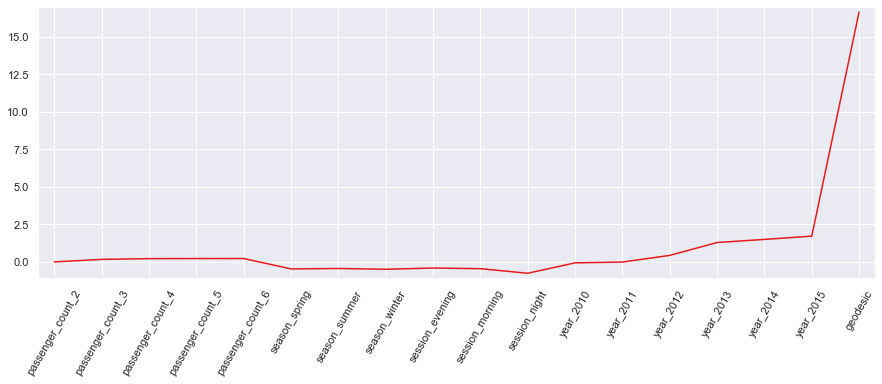

In [130]:
# Create the regressor: reg_all
reg_all = LinearRegression(copy_X= True, fit_intercept=True)

# Fit the regressor to the training data
reg_all.fit(X_train,y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))
test_scores(reg_all)

# Compute and print the coefficients
reg_coef = reg_all.coef_
print(reg_coef)

# Plot the coefficients
plt.figure(figsize=(15,5))
plt.plot(range(len(test.columns)), reg_coef)
plt.xticks(range(len(test.columns)), test.columns.values, rotation=60)
plt.margins(0.02)
plt.savefig('linear coefficients')
plt.show()

In [152]:
from sklearn.model_selection import cross_val_score
# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg,X,y,cv=5,scoring='neg_mean_squared_error')

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[-5.41570878 -5.35929026 -5.16726957 -5.34412733 -5.58426521]
Average 5-Fold CV Score: -5.374132231581629


# Decision Tree Regression

In [132]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15660 entries, 0 to 15660
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   fare_amount        15660 non-null  float64 
 1   passenger_count_2  15660 non-null  category
 2   passenger_count_3  15660 non-null  category
 3   passenger_count_4  15660 non-null  category
 4   passenger_count_5  15660 non-null  category
 5   passenger_count_6  15660 non-null  category
 6   season_spring      15660 non-null  category
 7   season_summer      15660 non-null  category
 8   season_winter      15660 non-null  category
 9   session_evening    15660 non-null  category
 10  session_morning    15660 non-null  category
 11  session_night      15660 non-null  category
 12  year_2010          15660 non-null  category
 13  year_2011          15660 non-null  category
 14  year_2012          15660 non-null  category
 15  year_2013          15660 non-null  category
 16  year

In [133]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': range(2,16,2),
              'min_samples_split': range(2,16,2)}

# Instantiate a Decision Tree regressor : tree
tree = DecisionTreeRegressor()

# Instantiate the GridSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 6, 'min_samples_split': 2}
Best score is 0.7254697409796774


[0.00000000e+00 4.91368625e-04 6.43352767e-04 9.07970488e-05
 5.29850597e-04 0.00000000e+00 0.00000000e+00 4.70193616e-04
 8.36352350e-04 0.00000000e+00 1.69021424e-03 1.84106857e-03
 0.00000000e+00 0.00000000e+00 1.05281279e-02 1.14220019e-02
 7.78124148e-03 9.63675431e-01]


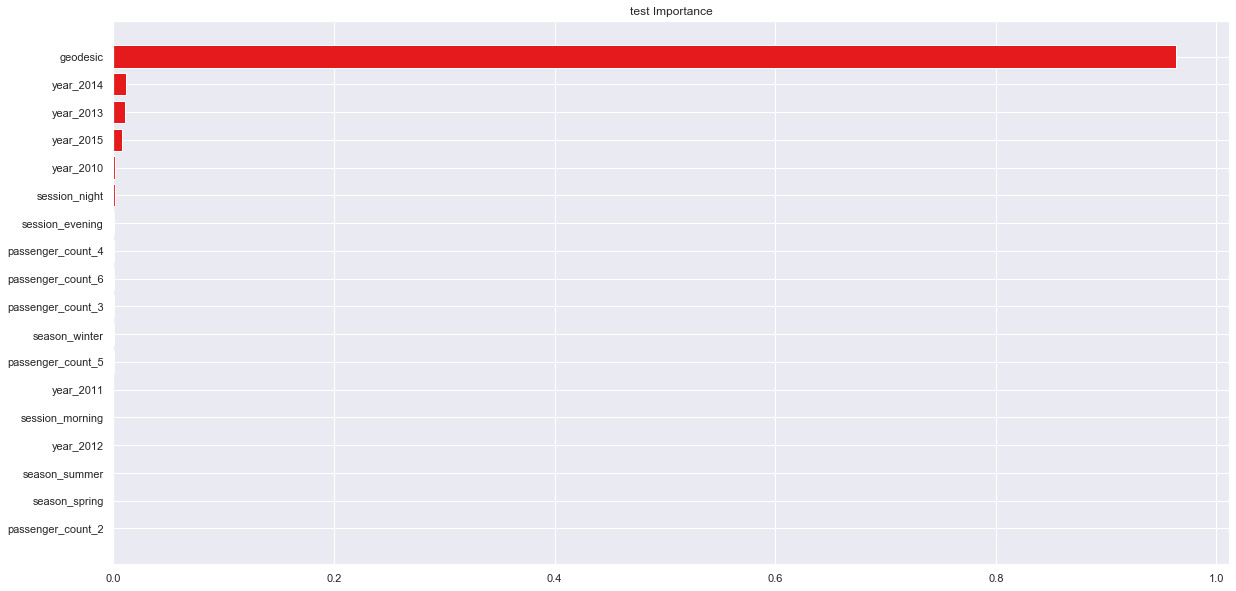

<<<------------------- Training Data Score --------------------->

r square   0.7438488737763356
Adjusted r square:0.7434556689092005
MAPE:18.619999204873285
MSE: 5.096825364246381
RMSE: 2.2576149725421253
RMSLE: 0.21028788768522555

<<<------------------- Test Data Score --------------------->

r square   0.733059587669241
Adjusted r square:0.731826290076337
MAPE:19.33044173179417
MSE: 5.477733362865773
RMSE: 2.340455802373925
RMSLE: 0.2145161730107812


In [134]:
# Instantiate a tree regressor: tree
tree = DecisionTreeRegressor(max_depth= 6, min_samples_split=2)

# Fit the regressor to the data
tree.fit(X_train,y_train)

# Compute and print the coefficients
tree_features = tree.feature_importances_
print(tree_features)

# Sort test importances in descending order
indices = np.argsort(tree_features)[::1]

# Rearrange test names so they match the sorted test importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("test Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),tree_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig('tree test importance')
plt.show()
# Make predictions and cal error
test_scores(tree)

# Random Forest Regression

In [135]:
random_grid = {'n_estimators': range(100,500,100),
               'max_depth': range(5,20,1),
               'min_samples_leaf':range(2,5,1),
              'max_features':['auto','sqrt','log2'],
              'bootstrap': [True, False],
              'min_samples_split': range(2,5,1)}
# Instantiate a Forest regressor: Forest
Forest = RandomForestRegressor()

# Instantiate the RandomizedSearchCV object: Forest_cv
Forest_cv = RandomizedSearchCV(Forest, random_grid, cv=5)

# Fit it to the data
Forest_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(Forest_cv.best_params_))
print("Best score is {}".format(Forest_cv.best_score_))


Tuned Random Forest Parameters: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 9, 'bootstrap': True}
Best score is 0.7421310526493559


[1.81510196e-03 1.07748417e-03 7.14905717e-04 9.24703628e-04
 5.45244157e-04 2.53725648e-03 3.19608873e-03 2.26487532e-03
 2.35016114e-03 2.35087766e-03 5.99553776e-03 2.80551091e-03
 1.04864598e-03 1.81727125e-03 1.07018977e-02 1.21540467e-02
 9.29171993e-03 9.38408671e-01]


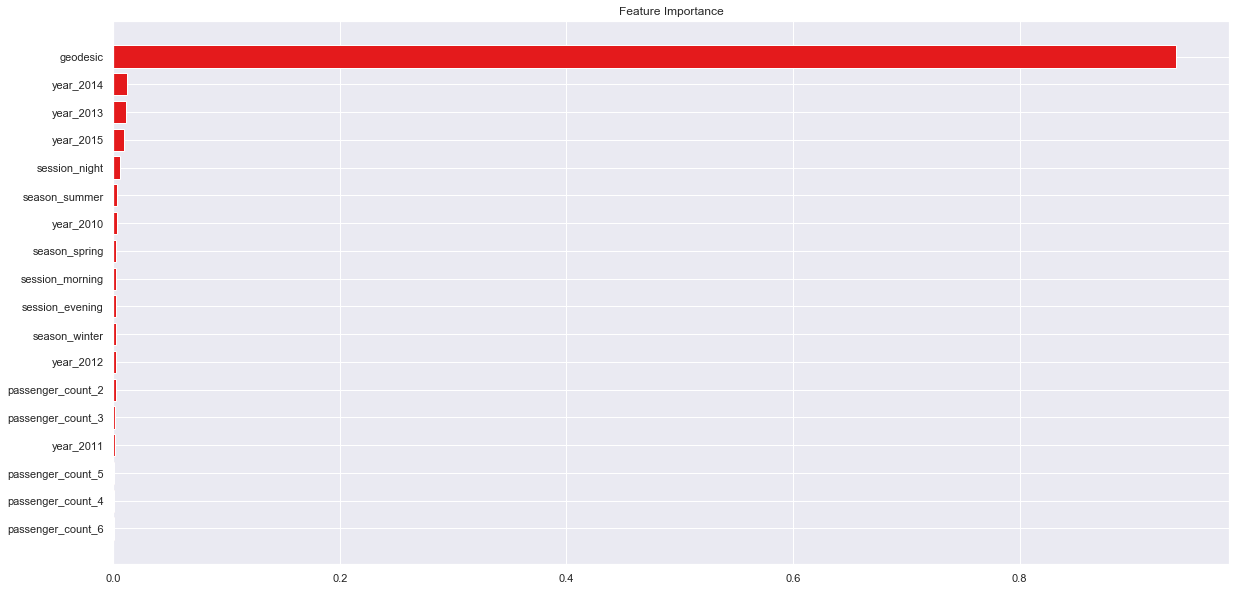

<<<------------------- Training Data Score --------------------->

r square   0.7871274696940171
Adjusted r square:0.7868006996492015
MAPE:16.95595134510112
MSE: 4.2356796466608895
RMSE: 2.0580766862925417
RMSLE: 0.1920534565965792

<<<------------------- Test Data Score --------------------->

r square   0.7490495633879379
Adjusted r square:0.747890141452872
MAPE:18.653412826324452
MSE: 5.149612106511409
RMSE: 2.2692756788260455
RMSLE: 0.2082672976899779


In [136]:
# Instantiate a Forest regressor: Forest
Forest = RandomForestRegressor(n_estimators=100, min_samples_split= 2, min_samples_leaf=4, max_features='auto', max_depth=9, bootstrap=True)

# Fit the regressor to the data
Forest.fit(X_train,y_train)

# Compute and print the coefficients
Forest_features = Forest.feature_importances_
print(Forest_features)

# Sort feature importances in descending order
indices = np.argsort(Forest_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),Forest_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig('Random forest feature importance')
plt.show()# Make predictions
test_scores(Forest)


In [137]:
from sklearn.model_selection import cross_val_score
# Create a random forest regression object: Forest
Forest = RandomForestRegressor(n_estimators=400, min_samples_split= 2, min_samples_leaf=4, max_features='auto', max_depth=12, bootstrap=True)

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(Forest,X,y,cv=5,scoring='neg_mean_squared_error')

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[-5.25450031 -5.20137311 -5.11904501 -5.18779421 -5.23595334]
Average 5-Fold CV Score: -5.199733197086224


# Improving accuracy using XGBOOST

In [139]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [140]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
cv_results.head()

[05:37:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,9.179423,0.019191,9.179101,0.083561
1,8.391931,0.067084,8.394786,0.145993
2,7.745220,0.072637,7.745935,0.099420
3,7.140102,0.074829,7.138448,0.031796
4,6.635466,0.091983,6.635219,0.051875


In [148]:
# the final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

49    2.680897
Name: test-rmse-mean, dtype: float64


In [142]:
Xgb = XGBRegressor()
Xgb.fit(X_train,y_train)
# pred_xgb = model_xgb.predict(X_test)
test_scores(Xgb)

<<<------------------- Training Data Score --------------------->

r square   0.8543928903524332
Adjusted r square:0.8541693761128241
MAPE:14.358349770456776
MSE: 2.897250621565923
RMSE: 1.702131199868542
RMSLE: 0.16166523686950937

<<<------------------- Test Data Score --------------------->

r square   0.7374763083367624
Adjusted r square:0.7362634165374968
MAPE:18.711191856370117
MSE: 5.387100333780003
RMSE: 2.321012781907933
RMSLE: 0.21252599330492317


In [143]:
# Create the random grid
para = {'n_estimators': range(100,500,100),
               'max_depth': range(3,10,1),
        'reg_alpha':np.logspace(-4, 0, 50),
        'subsample': np.arange(0.1,1,0.2),
        'colsample_bytree': np.arange(0.1,1,0.2),
        'colsample_bylevel': np.arange(0.1,1,0.2),
        'colsample_bynode': np.arange(0.1,1,0.2),
       'learning_rate': np.arange(.05, 1, .05)}
# Instantiate a XGB classifier: Forest
Xgb = XGBRegressor()

# Instantiate the randomizedSearchCV object: xgb_cv
xgb_cv = RandomizedSearchCV(Xgb, para, cv=5)

# Fit it to the data
xgb_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Xgboost Parameters: {}".format(xgb_cv.best_params_))
print("Best score is {}".format(xgb_cv.best_score_))

Tuned Xgboost Parameters: {'subsample': 0.1, 'reg_alpha': 0.08685113737513521, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.7000000000000001, 'colsample_bynode': 0.7000000000000001, 'colsample_bylevel': 0.9000000000000001}
Best score is 0.7449220725383129


[0.02028898 0.02003212 0.01934951 0.01900371 0.02042061 0.01865353
 0.0264211  0.02439802 0.02049802 0.0217641  0.03448646 0.03468926
 0.02831893 0.0195292  0.03891176 0.05413733 0.03902402 0.54007334]


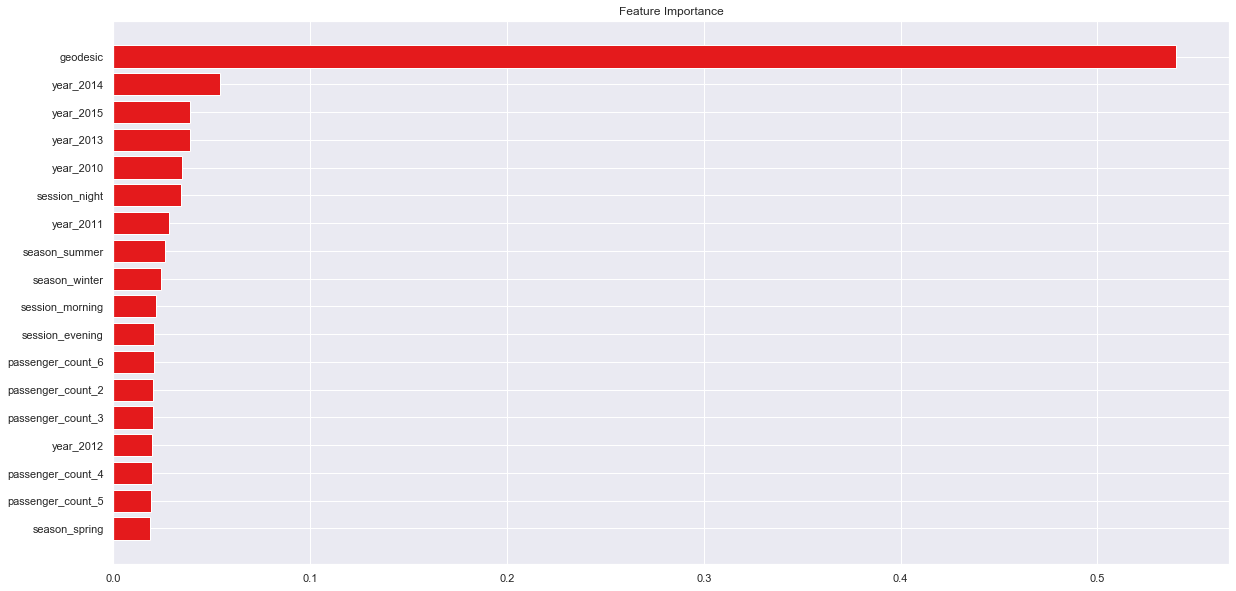

<<<------------------- Training Data Score --------------------->

r square   0.7513031693835526
Adjusted r square:0.7509214072352415
MAPE:18.193237006415256
MSE: 4.948501819924819
RMSE: 2.2245228297153568
RMSLE: 0.20588795308380312

<<<------------------- Test Data Score --------------------->

r square   0.7522177692306771
Adjusted r square:0.751072984796938
MAPE:18.46842367088717
MSE: 5.0845991446534855
RMSE: 2.2549055733341663
RMSLE: 0.206905220938097


In [144]:

# Instantiate a xgb regressor: Xgb
Xgb = XGBRegressor(subsample= 0.1, reg_alpha= 0.08685113737513521, n_estimators= 200, max_depth= 3, learning_rate=0.05, colsample_bytree= 0.7000000000000001, colsample_bynode=0.7000000000000001, colsample_bylevel=0.9000000000000001)

# Fit the regressor to the data
Xgb.fit(X_train,y_train)

# Compute and print the coefficients
xgb_features = Xgb.feature_importances_
print(xgb_features)

# Sort feature importances in descending order
indices = np.argsort(xgb_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [test.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,10))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X_train).shape[1]),xgb_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X_train).shape[1]), names)
plt.savefig(' xgb feature importance')
plt.show()# Make predictions
test_scores(Xgb)